In [14]:
import pandas as pd
import os
import numpy
from mlxtend.frequent_patterns import association_rules

In [15]:
# Preprocessing
data = pd.read_csv(r'../initial-data/Herbals and preperations.csv', encoding='latin-1')
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
data=data.dropna(subset=['bot_name'])
data['bot_name'] = data['bot_name'].str.strip()

data['author'] = data['author'].dropna(axis=0).str.strip()
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
data=data.dropna(subset=['bot_name'])
data['bot_name'] = data['bot_name'].str.strip()
columns_to_remove = ['herb_part', 'taste', 'potency', 'ultimate_taste', 'inherent_action']
data = data.drop(columns=columns_to_remove)

data.loc[data.bot_name.isin(['terminalia chebula', 'terminalia bellarica', 'phyllanthus emblica']), 'bot_name'] = 'triphala'
data.loc[data.bot_name.isin(['piper nigrum', 'piper longum', 'zingiber officinale']), 'bot_name'] = 'trikatu'
data.loc[(data.disease_category == 'diabetes') & (data.bot_name == 'saccharum officinarum'), 'bot_name'] = 'tinospora cordifolia'

In [16]:
# Convert all unique values in bot_name to a new series to be used as id
bot_name = data['bot_name'].unique()
bot_name = pd.Series(bot_name)
bot_name = bot_name.reset_index()
bot_name.columns = ['id', 'bot_name']
bot_name['id'] = bot_name['id'] + 1
if not os.path.exists(f'./split-data'):
    os.makedirs(f'./split-data')
bot_name.to_csv(r'./split-data/ids.csv', index=False)

In [17]:
# Splitting

data_dia = data.loc[data['disease_category'].apply(lambda x: x in ['diab/ tb ', 'diabetes'])].copy()
data_tub =  data.loc[data['disease_category'].apply(lambda x: x in ['diab/ tb ', 'tuberculosis '])].copy()
data_dia_aga = data_dia.loc[data_dia['author'].apply(lambda x: x in ['agathiyar'])]
data_dia_the = data_dia.loc[data_dia['author'].apply(lambda x: x in ['therayar'])]
data_tub_aga = data_tub.loc[data_tub['author'].apply(lambda x: x in ['agathiyar'])]
data_tub_the = data_tub.loc[data_tub['author'].apply(lambda x: x in ['therayar'])]

In [18]:
def write_split_data(data, name):
    # group using the id instead of name
    data = pd.merge(data, bot_name, on='bot_name', how='left')
    # Groupby drug and output id of all bot_names instead of name in the text file
    def remove_duplicates(row):
        numbers = row.split()
        unique_numbers = list(set(numbers))
        return ' '.join(unique_numbers)
    grouped_data = data.groupby('drug')['id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
    grouped_data['id'] = grouped_data['id'].apply(remove_duplicates)
    # grouped_data = data.groupby('drug')['bot_name'].apply(lambda x: ' '.join(x)).reset_index()
    # grouped_data
    # # Save the result to a text file
    with open(f'./split-data/{name}.txt', 'w') as f:
        for index, row in grouped_data.iterrows():
            f.write(row['id'] + '\n')

In [19]:
all_data = {
    'Diabetic-Data-Overall': data_dia,
    'Diabetic-Data-Agathiyar': data_dia_aga,
    'Diabetic-Data-Therayar': data_dia_the,
    'Tuberculosis-Data-Overall': data_tub,
    'Tuberculosis-Data-Agathiyar': data_tub_aga,
    'Tuberculosis-Data-Therayar': data_tub_the
    }

for name, data in all_data.items():
    write_split_data(data, name)

In [20]:
def runSPMF(algorithm:str, name:str, support:int = 15):
    # Create algorithm folder if not exists
    if not os.path.exists(f'./output-data/{algorithm}'):
        os.makedirs(f'./output-data/{algorithm}')
    # Run SPMF
    os.system( f"java -jar spmf.jar run {algorithm} ./split-data/{name}.txt ./output-data/{algorithm}/{name}.txt {support}%")
    # Read the result from the output txt file
    with open(f'./output-data/{algorithm}/{name}.txt', 'r') as f:
        # Read output in format => 52 53  #SUP: 
        result = f.read()
    # Split the result into lines
    result = result.split('\n')
    out_dic = {}
    for row in result:
        # Get the bot_name and support value
        if not row:
            continue
        values = row.split(' #SUP: ')
        out_dic[str(values[0])] = values[1]
    out_df = pd.DataFrame.from_dict(out_dic, orient='index').reset_index()
    # if out_df is empty create aan empty dataframe with columns ['bot_name', 'support']
    if out_df.empty:
        out_df = pd.DataFrame(columns=['bot_name', 'support'])

    # Out_dic to df
    out_df.columns = ['bot_name', 'support']
    # Rename columns
    
    def to_bot_name(row):
        ids = row.split()
        bot_names = []
        for id in ids:
            bot_names.append(bot_name.loc[bot_name['id'] == int(id), 'bot_name'].values[0])
        return bot_names
    
    # out_df['bot_name'] = out_df['bot_name'].apply(to_bot_name)
    
    return out_df


In [21]:
def create_association_rules(df: pd.DataFrame, name: str, min_threshold: float = 0.7):
    
    df = df.copy()

    # Convert the 'support' column to integers
    try:
        df['bot_name'] = df['bot_name'].str.split()
    # Convert the 'bot_name' lists to frozensets
    except Exception as e:
        print(df)
        print(name)
        print(min_threshold)
        raise e
    df['support'] = df['support'].astype(int)
    df['bot_name'] = df['bot_name'].apply(frozenset)
    df.rename(columns={'bot_name': 'itemsets'}, inplace=True)
    # Create association rules
    if df.empty:
        rules = pd.DataFrame(columns=['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'leverage', 'conviction'])
    else:
        rules = association_rules(df, metric='confidence', min_threshold=min_threshold)
        
    # If still empty print it in red color
    if rules.empty:
        print('\033[91m' + f'No rules found for {name} with min_threshold {min_threshold}' + '\033[0m')
    # Display the generated association rules
        
    return rules


In [22]:
# A function that calls run spmf and then create_association_rules to get association runs
def mean_performance(algorithm:str, name:str):
    support_list = [5, 10, 15, 20, 25]
    confidence_list = [0.5, 0.6, 0.7, 0.8]
    performance_score = 0
    for support in support_list:
        for confidence in confidence_list:
            supports = runSPMF(algorithm, name, support=support)
            rules = create_association_rules(supports, name, min_threshold=confidence)
            #
            rules.to_csv(f'./temp/{algorithm+name+"_"+str(support)+"_"+str(confidence)}')
            performance_score += len(rules)
    return numpy.mean(performance_score)

In [23]:
def get_algorithms_scores(name:str):
    algorithms = [
        'Apriori', 
        'FPGrowth_itemsets', 
        'Apriori_TID', 
        'Relim', 
        'Eclat'
        ]
    
    avg_scores = {}
    for algorithm in algorithms:
        avg_scores[algorithm] = mean_performance(algorithm, name=name)
    return avg_scores

In [24]:
# 'Diabetic-Data-Overall'
# 'Diabetic-Data-Agathiyar'
# 'Diabetic-Data-Therayar'
# 'Tuberculosis-Data-Overall'
# 'Tuberculosis-Data-Agathiyar'
# 'Tuberculosis-Data-Therayar'

# get_algorithms_scores('Diabetic-Data-Agathiyar')

In [34]:
sc = {}
def plot_scores(scores_dict, dataset_name):
    algorithms = list(scores_dict.keys())
    scores = list(scores_dict.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(algorithms, scores, color='skyblue')
    plt.xlabel('Algorithm')
    plt.ylabel('Average Performance Score')
    plt.title(f'Average Performance Scores of Algorithms on {dataset_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot for 'Diabetic-Data-Overall'


# Plot for 'Diabetic-Data-Agathiyar'



No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall

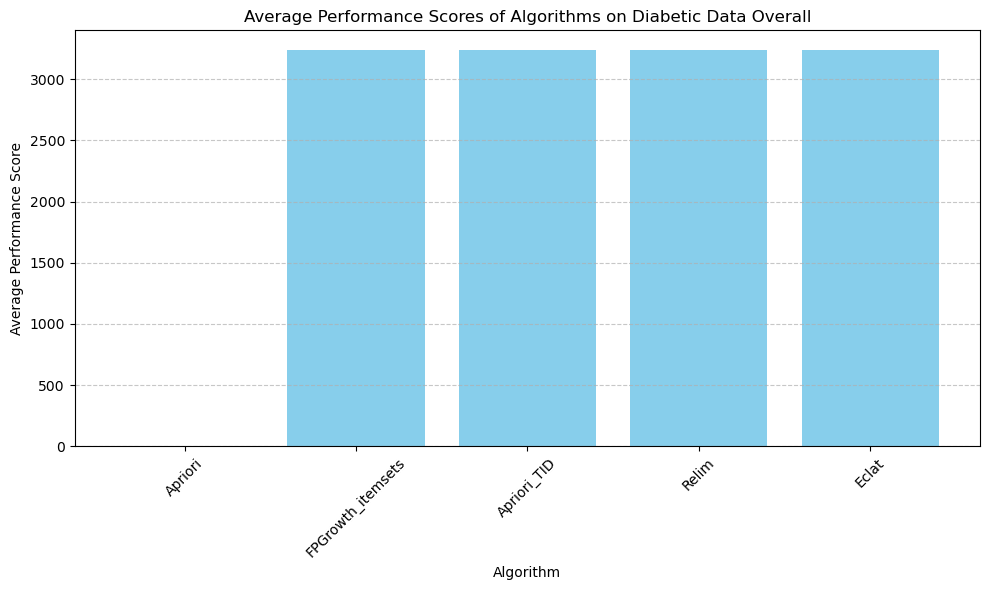

In [35]:
sc['Diabetic-Data-Overall'] = get_algorithms_scores(name='Diabetic-Data-Overall')
sc['Diabetic-Data-Overall']
plot_scores(sc['Diabetic-Data-Overall'], 'Diabetic Data Overall')


No rules found for Diabetic-Data-Agathiyar with min_threshold 0.5
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.6
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.7
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.8
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.5
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.6
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.7
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.8
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.5
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.6
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.7
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.8
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.5
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.6
No rules found for Diabetic-Data-Agathiyar with min_threshold 0.7
No rules f

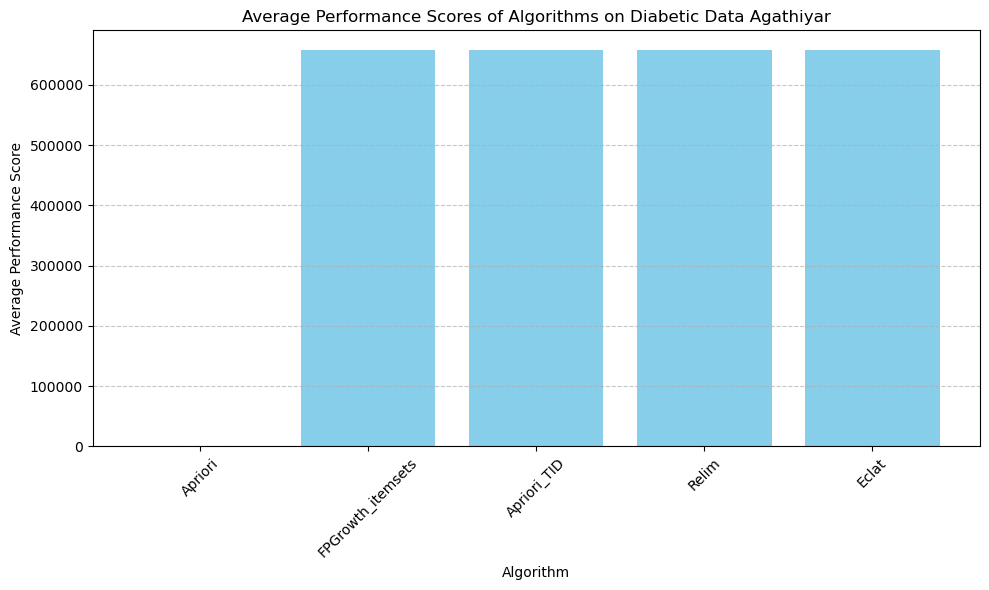

In [37]:

sc['Diabetic-Data-Agathiyar'] =get_algorithms_scores(name='Diabetic-Data-Agathiyar')
sc['Diabetic-Data-Agathiyar']
plot_scores(sc['Diabetic-Data-Agathiyar'], 'Diabetic Data Agathiyar')

No rules found for Diabetic-Data-Therayar with min_threshold 0.5
No rules found for Diabetic-Data-Therayar with min_threshold 0.6
No rules found for Diabetic-Data-Therayar with min_threshold 0.7
No rules found for Diabetic-Data-Therayar with min_threshold 0.8
No rules found for Diabetic-Data-Therayar with min_threshold 0.5
No rules found for Diabetic-Data-Therayar with min_threshold 0.6
No rules found for Diabetic-Data-Therayar with min_threshold 0.7
No rules found for Diabetic-Data-Therayar with min_threshold 0.8
No rules found for Diabetic-Data-Therayar with min_threshold 0.5
No rules found for Diabetic-Data-Therayar with min_threshold 0.6
No rules found for Diabetic-Data-Therayar with min_threshold 0.7
No rules found for Diabetic-Data-Therayar with min_threshold 0.8
No rules found for Diabetic-Data-Therayar with min_threshold 0.5
No rules found for Diabetic-Data-Therayar with min_threshold 0.6
No rules found for Diabetic-Data-Therayar with min_threshold 0.7
No rules found for Diabet

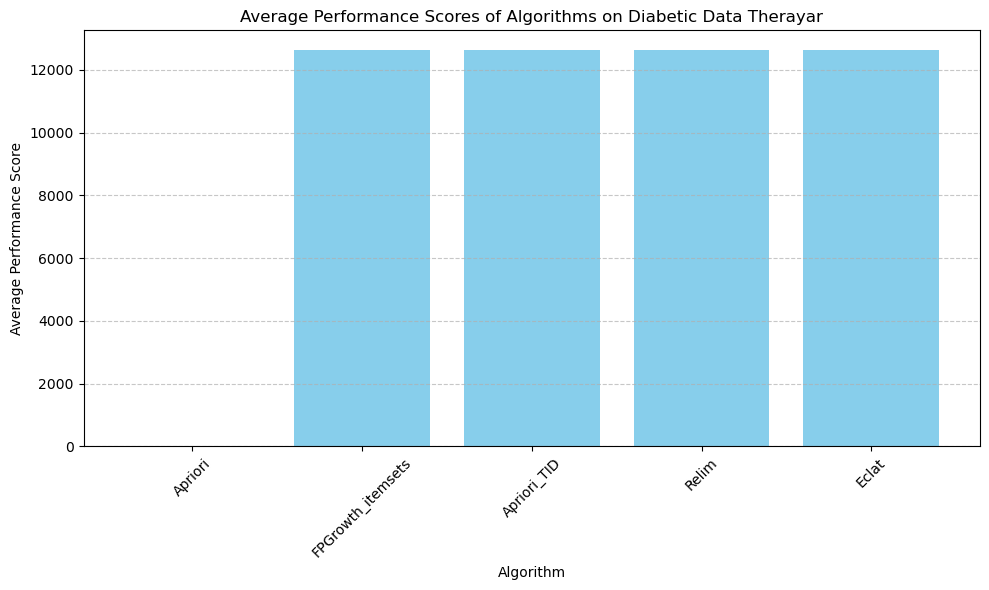

In [38]:
sc['Diabetic-Data-Therayar'] = get_algorithms_scores(name='Diabetic-Data-Therayar')
sc['Diabetic-Data-Therayar']
plot_scores(sc['Diabetic-Data-Therayar'], 'Diabetic Data Therayar')

No rules found for Tuberculosis-Data-Overall with min_threshold 0.5
No rules found for Tuberculosis-Data-Overall with min_threshold 0.6
No rules found for Tuberculosis-Data-Overall with min_threshold 0.7
No rules found for Tuberculosis-Data-Overall with min_threshold 0.8
No rules found for Tuberculosis-Data-Overall with min_threshold 0.5
No rules found for Tuberculosis-Data-Overall with min_threshold 0.6
No rules found for Tuberculosis-Data-Overall with min_threshold 0.7
No rules found for Tuberculosis-Data-Overall with min_threshold 0.8
No rules found for Tuberculosis-Data-Overall with min_threshold 0.5
No rules found for Tuberculosis-Data-Overall with min_threshold 0.6
No rules found for Tuberculosis-Data-Overall with min_threshold 0.7
No rules found for Tuberculosis-Data-Overall with min_threshold 0.8
No rules found for Tuberculosis-Data-Overall with min_threshold 0.5
No rules found for Tuberculosis-Data-Overall with min_threshold 0.6
No rules found for Tuberculosis-Data-Overall wit

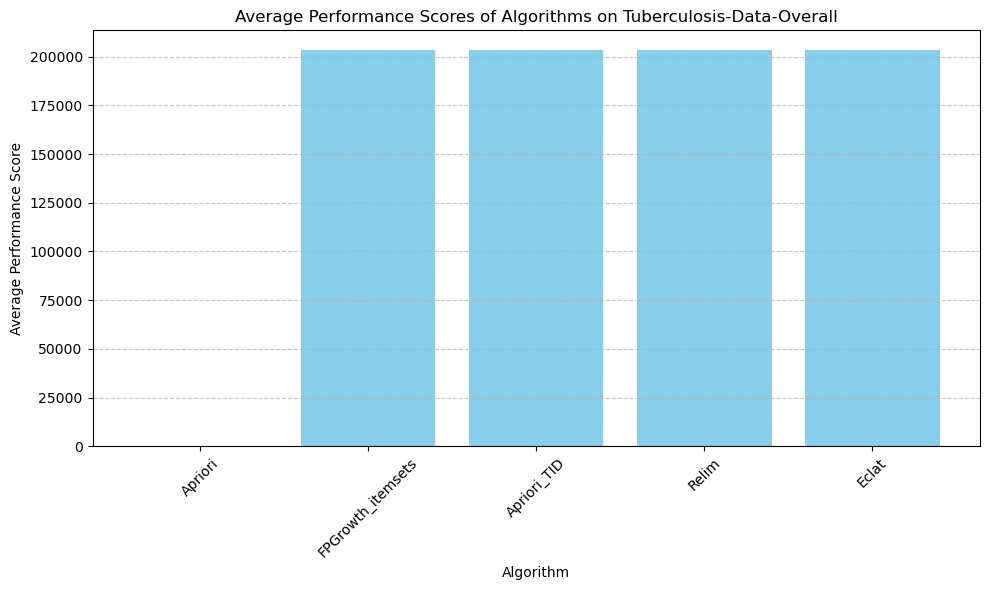

In [39]:
sc['Tuberculosis-Data-Overall'] = get_algorithms_scores(name='Tuberculosis-Data-Overall')
sc['Tuberculosis-Data-Overall']
plot_scores(sc['Tuberculosis-Data-Overall'], 'Tuberculosis-Data-Overall')

No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.5
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.6
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.7
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.8
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.5
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.6
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.7
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.8
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.5
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.6
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.7
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.8
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.5
No rules found for Tuberculosis-Data-Agathiyar with min_threshold 0.6
No rules found for T

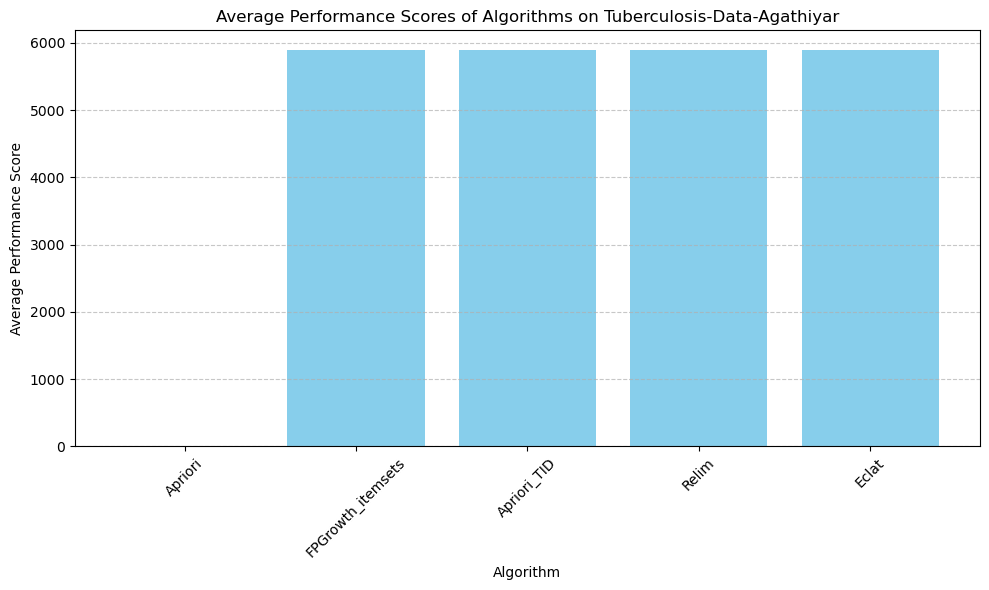

In [40]:
sc['Tuberculosis-Data-Agathiyar'] = get_algorithms_scores(name='Tuberculosis-Data-Agathiyar')
sc['Tuberculosis-Data-Agathiyar']
plot_scores(sc['Tuberculosis-Data-Agathiyar'], 'Tuberculosis-Data-Agathiyar')

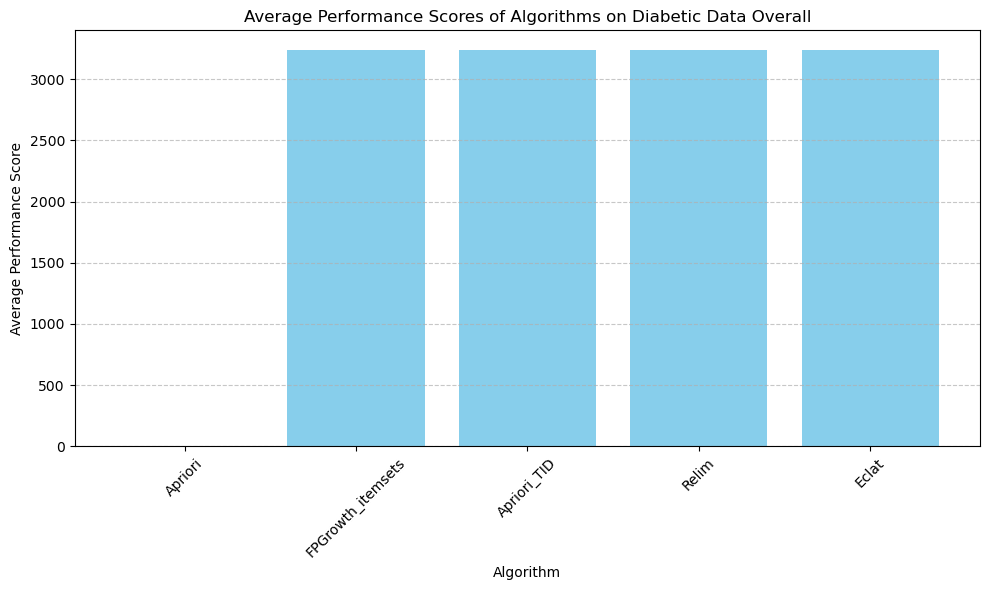

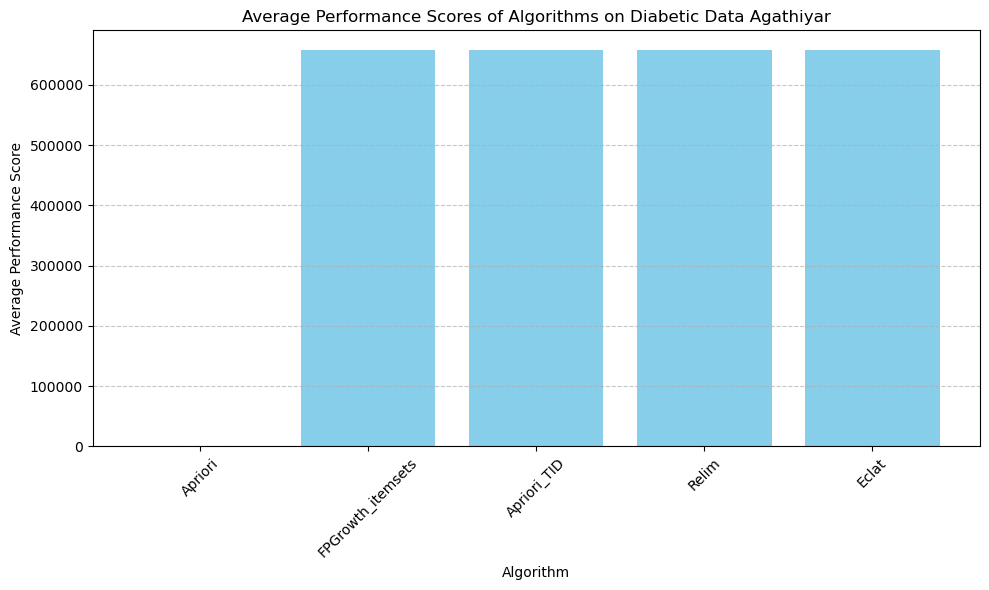

In [31]:
import matplotlib.pyplot as plt

# Function to plot the scores
plot_scores(sc['Diabetic-Data-Therayar'], 'Diabetic Data Therayar')
plot_scores(sc['Tuberculosis-Data-Overall'], 'Tuberculosis-Data-Overall')
plot_scores(sc['Tuberculosis-Data-Agathiyar'], 'Tuberculosis-Data-Agathiyar')

In [45]:
# A function that calls run spmf and then create_association_rules to get association runs
def mean_performance(algorithm:str, name:str):
    support_list = [ 15,20, 25]
    confidence_list = [ 0.6,0.7, 0.8]
    performance_score = 0
    for support in support_list:
        for confidence in confidence_list:
            supports = runSPMF(algorithm, name, support=support)
            rules = create_association_rules(supports, name, min_threshold=confidence)
            #
            rules.to_csv(f'./temp/{algorithm+name+"_"+str(support)+"_"+str(confidence)}')
            performance_score += len(rules)
    return numpy.mean(performance_score)

No rules found for Tuberculosis-Data-Therayar with min_threshold 0.6
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.7
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.8
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.6
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.7
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.8
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.6
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.7
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.8
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.6
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.7
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.8
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.6
No rules found for Tuberculosis-Data-Therayar with min_threshold 0.7
No rules found for Tuberculosis-Da

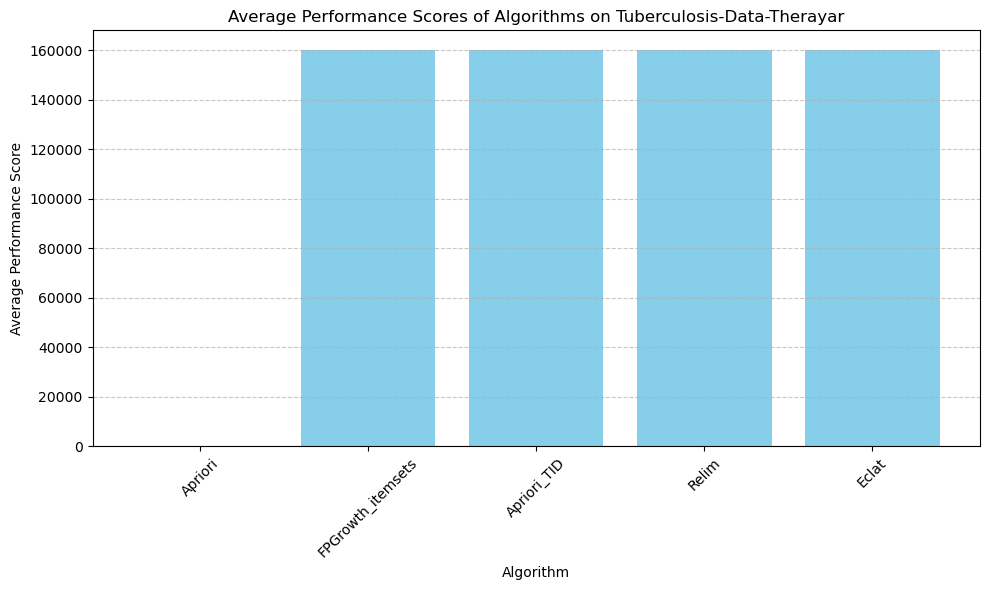

In [46]:
sc['Tuberculosis-Data-Therayar'] = get_algorithms_scores(name='Tuberculosis-Data-Therayar')
sc['Tuberculosis-Data-Therayar']
plot_scores(sc['Tuberculosis-Data-Therayar'], 'Tuberculosis-Data-Therayar')

In [ ]:
plt.

In [33]:
data_scores = {}
for name, data in all_data.items():
    data_scores[name] = get_algorithms_scores(name=name)

No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall with min_threshold 0.8
No rules found for Diabetic-Data-Overall with min_threshold 0.5
No rules found for Diabetic-Data-Overall with min_threshold 0.6
No rules found for Diabetic-Data-Overall with min_threshold 0.7
No rules found for Diabetic-Data-Overall


KeyboardInterrupt



In [ ]:
data_scores

In [ ]:
sc['Diabetic-Data-Overall'] = get_algorithms_scores(name='Diabetic-Data-Overall')
sc['Diabetic-Data-Overall']
plot_scores(sc['Diabetic-Data-Overall'], 'Diabetic Data Overall')
